In [1]:
# show all warnings

import warnings as _wrn
_wrn.filterwarnings('always')

In [2]:
# import various packages

import sys as _sys
import pickle as _pkl
import itertools as _itr

import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import scipy.stats as _sts
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_plt.style.use('ggplot')

In [3]:
# import eQTLseq

import eQTLseq as _assoc

In [4]:
# load simulated data, or ...

with open('data/simdata.pkl', 'rb') as fh:
    data = _pkl.load(fh)

(1000, 100) (50, 1000)


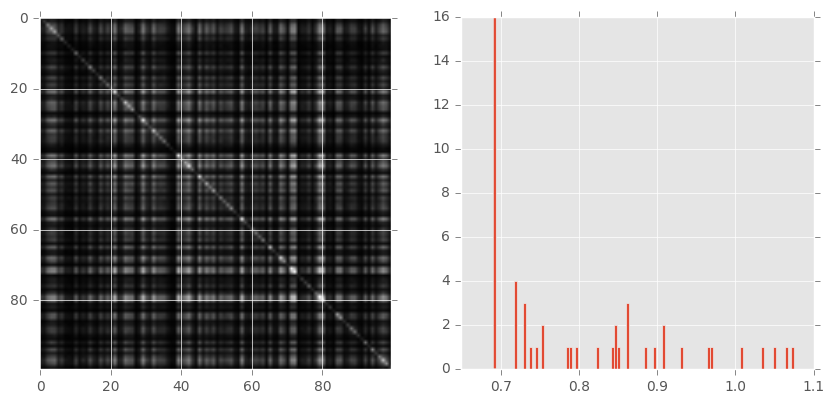

In [32]:
# prepare data

Z = data['Z']
G = data['G']

Z = Z[Z.sum(1) > 0, :]       # keep only expressed tags
# Z = Z[Z.sum(1) > _nmp.percentile(Z.sum(1), 60), :]
G = G[:, _nmp.std(G, 0) > 0] # keep only non-monomorphic loci

# Z = Z / _assoc.calculate_norm_factors(Z)
Z = _assoc.transform_data(Z, kind='vst')

print(G.shape, Z.shape)

# take a quick look at the data

_plt.figure(figsize=(10,10));
_plt.subplot(2,2,1); _plt.imshow(G.T.dot(G), cmap=_plt.cm.Greys_r);
_plt.subplot(2,2,2); _plt.hist(_nmp.log10(Z[:, 0] + 1), bins=100);

In [33]:
# estimate model
_rnd.seed(0)
res = _assoc.run(Z.T, G, n_iters = 2000, model='Normal', scaleG=True, n_threads=1)

/Users/dimitris/VEnvs/py35/lib/python3.5/site-packages/tqdm/_tqdm.py:65: DeprecationWarning: sys.getcheckinterval() and sys.setcheckinterval() are deprecated.  Use sys.setswitchinterval() instead.
  sys.setcheckinterval(100)
100%|██████████| 2000/2000 [00:06<00:00, 294.60it/s]


([0.69442019484825213, 0.75, 0.25, 6, 2, 4990, 2], 0.44239283812448366)

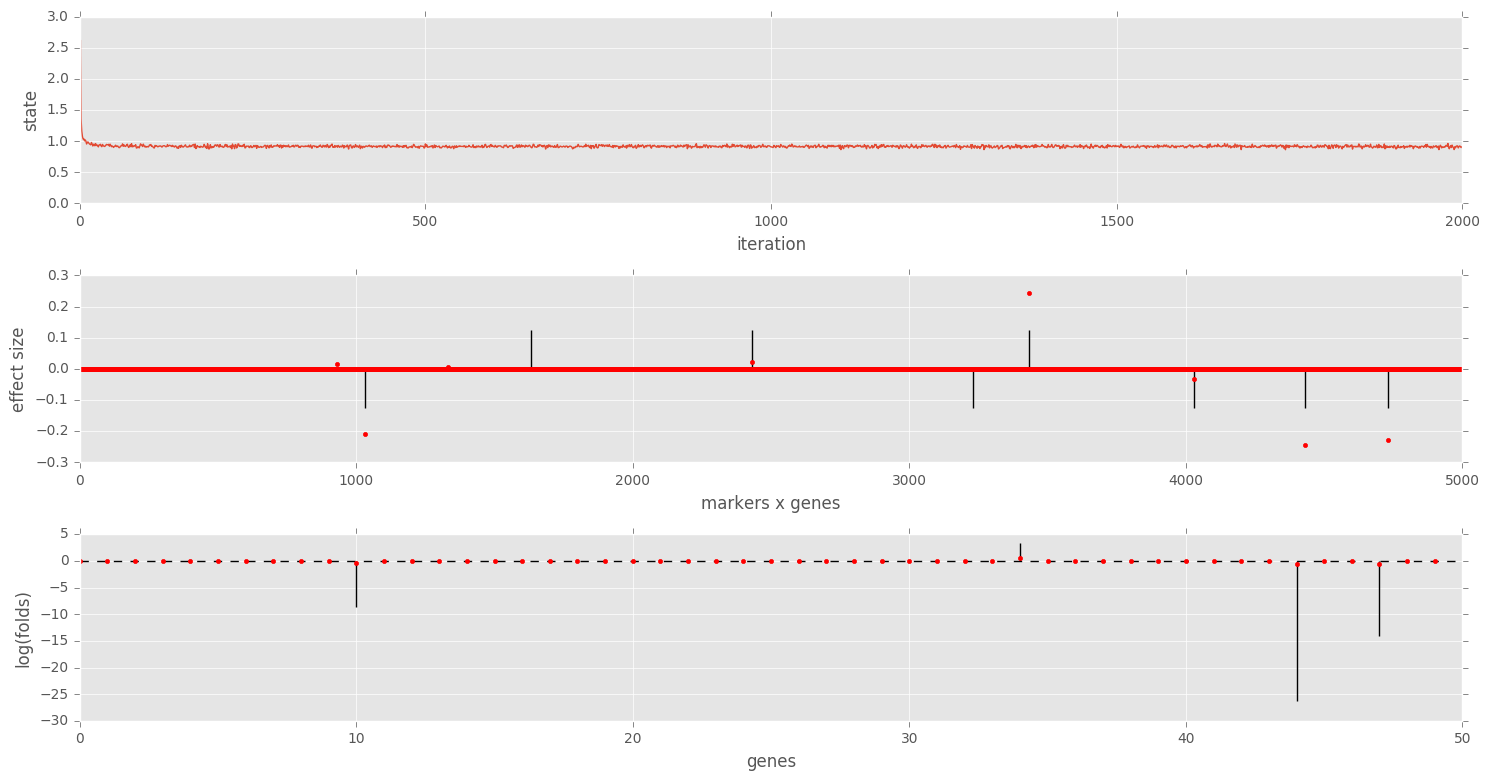

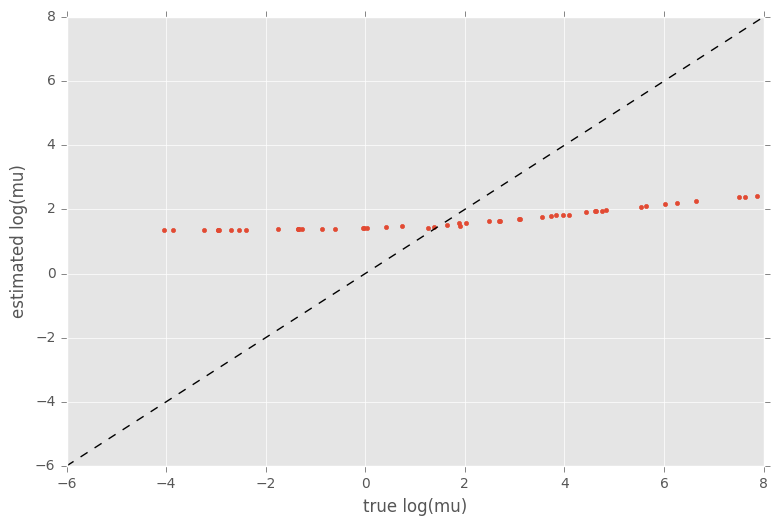

In [34]:
def fcn():
    _plt.figure(figsize = (15,10));
    _plt.subplot(4,1,1); _plt.plot(res['state']); _plt.xlabel('iteration'); _plt.ylabel('state')

    beta_estim = res['beta'] / _nmp.abs(res['beta']).sum()
    beta_true = data['beta'] / _nmp.abs(data['beta']).sum()
    n_genes, n_markers = beta_true.shape

    _plt.subplot(4,1,2); 
    _plt.vlines(range(n_markers * n_genes), 0, beta_true.ravel()); 
    _plt.axhline(linestyle='--', color='k');
    _plt.plot(beta_estim.ravel(), 'r.'); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')

    if 'mu' in res:
        G = data['G']
    #     G = (G - _nmp.mean(G, 0)) / _nmp.std(G, 0)
        folds_true = _nmp.mean(G.dot(beta_true.T), 0) * data['mu']
        folds_estim = _nmp.mean(G.dot(beta_estim.T), 0) * res['mu']
        n_samples, _ = G.shape
        _plt.subplot(4,1,3); 
        _plt.vlines(range(n_genes), 0, folds_true.ravel()); 
        _plt.axhline(linestyle='--', color='k');
        _plt.plot(folds_estim.ravel(), 'r.'); _plt.xlabel('genes'); _plt.ylabel('log(folds)')
    
    if 'Y' in res:
        _plt.subplot(4,1,4); 
        _plt.plot(res['Y'].ravel(), 'r.'); _plt.xlabel('genes'); _plt.ylabel('log(folds)')
        _plt.axhline(linestyle='--', color='k');

    _plt.tight_layout()
        
    if 'mu' in res:
        _plt.figure(figsize = (15,10))
        _plt.subplot(2,2,1)
        _plt.plot(_nmp.log(data['mu']), _nmp.log(res['mu']), '.'); _plt.ylim(_plt.xlim()); 
        _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
        _plt.xlabel('true log(mu)'); _plt.ylabel('estimated log(mu)')

        if 'phi' in res:
            var_tru = data['mu'] + data['phi'] * data['mu']**2
            var_est = res['mu'] + res['phi'] * res['mu']**2
            
            _plt.subplot(2,2,2)
            _plt.plot(_nmp.log(var_tru), _nmp.log(var_est), '.'); _plt.ylim(_plt.xlim()); 
            _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
            _plt.xlabel('true log(var)'); _plt.ylabel('estimated log(var)')

            _plt.subplot(2,2,3)
            _plt.plot(_nmp.log(data['phi']), _nmp.log(res['phi']), '.'); _plt.ylim(_plt.xlim()); 
            _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
            _plt.xlabel('true log(phi)'); _plt.ylabel('estimated log(phi)')
                        
    _plt.tight_layout()

    return _assoc.calculate_metrics(res['beta'], data['beta'])

##
metrics = fcn()
[metrics[_] for _ in ['RSS', 'TPR', 'FDR', 'TP', 'FP', 'TN', 'FN']], metrics['MCC']/(metrics['RSS'] + 1)

In [ ]:
G = (data['G'] - _nmp.mean(data['G'], 0)) / _nmp.std(data['G'], 0)
folds = G.dot(data['beta'].T)
_plt.figure(); _plt.hist(folds[folds!=0], 100)
_plt.figure(); _plt.boxplot(_nmp.exp(_nmp.abs(folds))[folds!=0])
_nmp.min(_nmp.abs(folds[folds!=0])), _nmp.max(_nmp.abs(folds[folds!=0]))

In [ ]:
G = _nmp.loadtxt('data/1000G_chr7_100K_200K_005pc_5pc.txt', dtype='int')
maf = G.sum(0) / (2 * G.shape[0])
_plt.hist(maf, 100);

In [ ]:
_nmp.exp((2.5, 1.3862943611198908))

In [ ]:
data['outliers'][0].size

In [ ]:
M = GENO[:,:100].T.dot(GENO[:,:100])
_plt.figure(figsize=(10,10));
_plt.imshow(M, cmap=_plt.cm.Greys_r);

In [ ]:
G = _assoc.simulate_genotypes(MAF, *GENO.shape)['G']
_plt.figure(figsize=(10,10));
_plt.imshow(G.T.dot(G), cmap=_plt.cm.Greys_r);

In [ ]:
import scipy.signal as _sgn

In [ ]:
_nmp.correlate([0,0,0,0,1,0,0,0,0],[0,0,0,0,1,,0,0,0])

In [ ]:
_plt.matshow(data['outliers'])
_nmp.sum(data['outliers'], 0)

In [ ]:
0.05 * 50

In [ ]:
tmp = _rnd.choice([True, False], size = (100, 50), p = [0.05, 1 - 0.05])

In [ ]:
tmp.sum()

In [ ]:
276/5000

In [ ]:
tmp.sum(1)

In [ ]:
x = _rnd.rand(10,3)
row_idxs = [1,5,7]
col_idxs = [1,2,1]
x[row_idxs, col_idxs] = 0

In [ ]:
100*50

In [ ]:
_assoc.get_error(Z.T, G, res, model = 'Normal')

In [ ]:
_assoc.get_error(Z.T, G, res, model = 'NBinomial')

In [ ]:
_assoc.get_error(Z.T, G, res, model = 'Poisson')

In [ ]:
_assoc.get_error(Z.T, G, res, model = 'Binomial')

In [ ]:
452*0.5

In [14]:
_assoc.get_metrics(Z.T, G, res, model='NBinomial', scaleG=True)

{'PCC': 0.97342801703795168,
 'R2': 1.0,
 'RHO': 0.93620246155218856,
 'X2': 23.24474561434678,
 'X2p': 1.0691938148662414,
 'nMSE': 0.27591471513772053}

In [11]:
_assoc.get_metrics(Z.T, G, res, model='Binomial', scaleG=True)

{'PCC': 0.97626204304224562,
 'R2': 1.0,
 'RHO': 0.93794848351663151,
 'X2': 145.00558526448657,
 'X2p': 147.48784016578327,
 'nMSE': 0.2600542471752636}

In [8]:
_assoc.get_metrics(Z.T, G, res, model='Poisson', scaleG=True)

{'PCC': 0.9765338561494824,
 'R2': 1.0,
 'RHO': 0.93833070989736111,
 'X2': 140.09194687107041,
 'X2p': 140.09194687107041,
 'nMSE': 0.2604753444054525}

In [35]:
_assoc.get_metrics(Z.T, G, res, model='Normal', scaleG=True)

{'PCC': 0.98440782105760605,
 'R2': 1.0,
 'RHO': 0.93897778925653419,
 'X2': 0.023332977501982346,
 'X2p': 0.99871778940991718,
 'nMSE': 0.26128032572670107}

In [18]:
_nmp.log(0.01)

-4.6051701859880909

In [63]:
'123' + '4'

'1234'

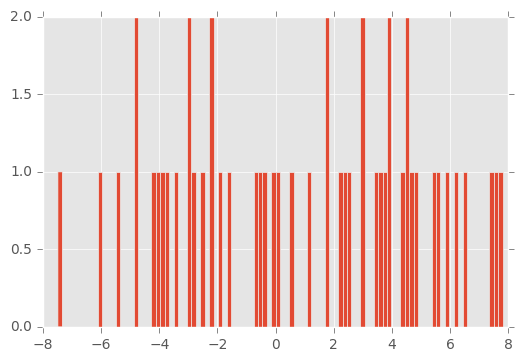

In [19]:
_plt.hist(_nmp.mean(res['Y'], 0), 100);

In [16]:
Z.shape

(50, 1000)